In [ ]:
from n2n4m.crism_image import CRISMImage
from n2n4m.plot import Visualiser
from n2n4m.n2n4m_denoise import clip_bands
from n2n4m.preprocessing import impute_bad_values_in_image
from n2n4m.wavelengths import PLEBANI_WAVELENGTHS, ALL_WAVELENGTHS
from n2n4m.type_spectra import CRISM_diagnostic_mineral_features, get_type_spectra, clip_type_spectra, get_type_spectra_name, get_type_spectra_class

from torch.utils.data import DataLoader
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from hm4.labelling import CLASS_NAMES, PLATT_TO_PLEBANI
from hm4.VAE_classifier_248 import VAEClassifier
from hm4.plot import convert_to_coords_filter_regions_by_conf, mineral_colours

In [96]:
plt.rcParams["svg.fonttype"] = "none"

In [ ]:
IMAGE_FILEPATH = # Insert path to the CRISM image HRL000040FF here. This must have had the volcano-scan correction applied.
CRISM_ML_DIR = # Insert path to the CRISM_ML directory here
MODEL_WEIGHTS_PATH = # Insert path to the model weights .pth file here
TYPE_SPECTRA_PATH = # insert the path to the local copy of the CRISM/MICA type spectra here

In [ ]:
image = CRISMImage(IMAGE_FILEPATH)

Image loaded successfully.


In [3]:
# vertical and horizontal flip image to correct for ascending pass geometry
image.image_array = np.flip(image.image_array, axis=0)
image.image_array = np.flip(image.image_array, axis=1)

In [ ]:
image.ratio_image(CRISM_ML_DIR)
image.calculate_summary_parameter("CINDEX2")
image.calculate_summary_parameter("hyd_femg_clay_index")
image.calculate_summary_parameter("LCPINDEX2")
image.calculate_summary_parameter("HCPINDEX2")

/scratch_dgxl/rp1818/miniconda3/envs/pixel_classifier/lib/python3.11/site-packages/n2n4m/preprocessing.py:263: RuntimeWarning: Mean of empty slice
  image_copy = np.nan_to_num(image_copy, nan=np.nanmean(image_copy, axis=0))
/scratch_dgxl/rp1818/miniconda3/envs/pixel_classifier/lib/python3.11/site-packages/crism_ml/preprocessing.py:410: RuntimeWarning: invalid value encountered in divide
  normed = pixspec[idx, :, :] / bland
/scratch_dgxl/rp1818/miniconda3/envs/pixel_classifier/lib/python3.11/site-packages/n2n4m/summary_parameters.py:143: RuntimeWarning: invalid value encountered in divide
  band_depth = center_ref / interpolated_center_ref
/scratch_dgxl/rp1818/miniconda3/envs/pixel_classifier/lib/python3.11/site-packages/n2n4m/summary_parameters.py:226: RuntimeWarning: invalid value encountered in divide
  relative_band_depth = (


In [5]:
ratioed_im = image.ratioed_image
# flatten and drop extra bands
im_shape = image.im_shape
ratioed_im = ratioed_im.reshape(-1, 438) # 438 bands
ratioed_im, _ = clip_bands(ratioed_im)
ratioed_im = ratioed_im[:, :248] # 248 bands to use for the model
ratioed_im, _ = impute_bad_values_in_image(ratioed_im, threshold=10)
# normalise
ratioed_im = torch.tensor(ratioed_im.astype(np.float32))
min_vals = torch.min(ratioed_im, dim=-1, keepdim=True).values
max_vals = torch.max(ratioed_im, dim=-1, keepdim=True).values
ratioed_im_scaled = (ratioed_im - min_vals) / ((max_vals - min_vals)+0.00001)

In [ ]:
data_loader = DataLoader(ratioed_im_scaled, batch_size=256, shuffle=False)
model = VAEClassifier(n_blocks=1, n_conv_layers=1, zx_dim=16, zy_dim=16, n_classes=38)
model.load_state_dict(torch.load(MODEL_WEIGHTS_PATH, map_location=torch.device('cpu')))

<All keys matched successfully>

In [7]:
y_pred_list = []
x_recon_arr = []
for x in data_loader:
    x_recon, y_pred = model.reconstruct_classify(x.unsqueeze(1))
    y_pred_list.append(y_pred.detach().numpy())
    x_recon_arr.append(x_recon.detach().numpy())
y_pred_probs = torch.tensor(np.concatenate(y_pred_list, axis=0))
y_pred = torch.argmax(y_pred_probs, axis=1)
x_recon = torch.tensor(np.concatenate(x_recon_arr, axis=0)).reshape(-1, 248)

In [8]:
# inverse transform
x_recon = x_recon * (max_vals - min_vals) + min_vals
x_recon = x_recon.detach().numpy().reshape((*im_shape[:2], 248))

Text(0, 0.5, 'Confidence')

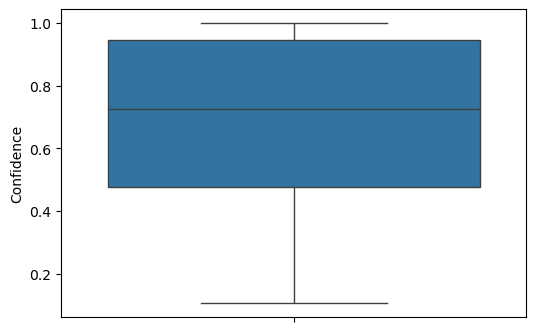

In [ ]:
# boxplot the confidence of the model
fig, ax = plt.subplots(figsize=(6, 4))
sns.violinplot(y=y_pred_probs.max(dim=1)[0], ax=ax)
ax.set_ylabel("Confidence")

In [10]:
y_pred_im = y_pred.reshape(im_shape[:2])
confidence_scores = y_pred_probs.max(dim=1)[0].reshape(im_shape[:2]).squeeze(1)

In [11]:
predictions = np.unique(y_pred_im, return_counts=True)

In [12]:
pred_labels = [CLASS_NAMES[val] for val in predictions[0]]
pred_counts = predictions[1]

pred_df = pd.DataFrame({"Class": pred_labels, "Count": pred_counts})
pred_df.sort_values("Count", ascending=False, inplace=True)
pred_df

Class  Count
27                        MgCO3  54899
6                      Saponite  21879
33             Olivine Fayalite  19854
34                     Chloride  19390
1                       H2O Ice   8698
30              Low Ca Pyroxene   7000
5                    Nontronite   5526
23         Monohydrated sulfate   2959
9                    Serpentine   2220
32             High Ca Pyroxene   1908
24                       Opal 1   1474
8                      Jarosite   1186
19                   Halloysite   1125
20             Illite/Muscovite    814
11                   Akaganeite    639
35                     Artefact    635
12                    Ca/Fe CO3    611
22                     Analcime    386
26  Iron Oxide Silicate Sulfate    383
17                     Rosenite    345
29                  Clinochlore    306
18                   Mg Cl salt    294
0                       CO2 Ice    213
7                      Prehnite    183
2                        Gypsum    169
28                     Chlorite    147
4                      Hematite    108
14                    Kaolinite    104
10                      Alunite     53
25                       Opal 2     44
31           Olivine Forsterite     21
3         Ferric Hydroxysulfate      9
21                    Margarite      8
15                      Epidote      5
16              Montmorillonite      3
13                   Beidellite      2

In [13]:
static_vis = Visualiser(image)

In [14]:
pred_coords = convert_to_coords_filter_regions_by_conf(y_pred_im, confidence_scores, min_area=19, min_confidence=0.75)
pred_coords = {k: v for k, v in sorted(pred_coords.items(), key=lambda item: len(item[1]), reverse=True)}

/scratch_dgxl/rp1818/miniconda3/envs/pixel_classifier/lib/python3.11/site-packages/n2n4m/plot.py:105: UserWarning: Bad values detected in the image. A copy has been made, values > 1000 will be replaced with np.nan.
  warnings.warn(


(-0.5, 319.5, 479.5, -0.5)

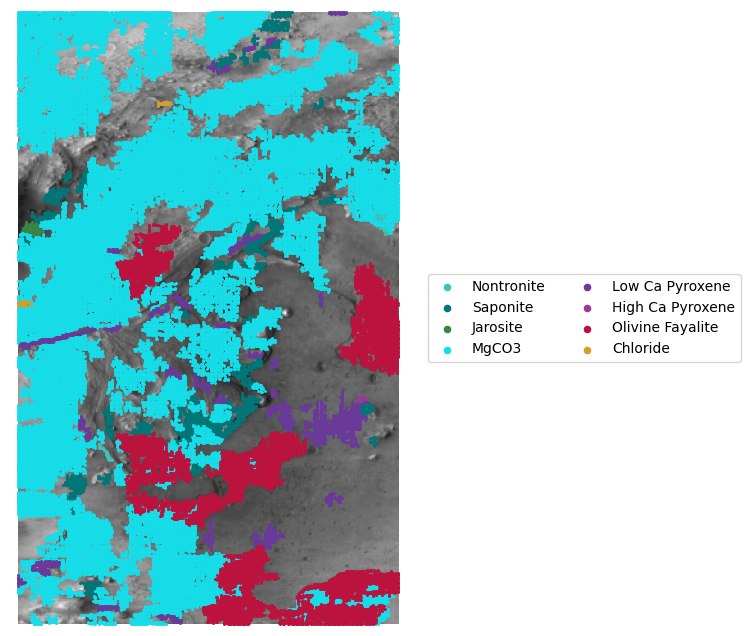

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(static_vis.get_image(60), cmap="gray")
for i, (pred_class, coords) in enumerate(pred_coords.items()):
    if pred_class == 1: # skip h20 ice 
        continue 
    if len(coords) > 1:
        ax.scatter(coords[0], coords[1], s=1.3, color=mineral_colours[CLASS_NAMES[pred_class]], label=f"{CLASS_NAMES[pred_class]}")

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', ncols=2, bbox_to_anchor=(1, 0.5))

for handle in ax.get_legend().legend_handles:
    handle.set_sizes([20])

ax.axis('off')

In [16]:
# pred_im_filtered = np.full_like(y_pred_im, 65535.0)
# for pred_class, coords in pred_coords.items():
#     if len(coords) > 0:
#         pred_im_filtered[coords[1], coords[0]] = pred_class

In [17]:
# denoised_ratioed_im = np.zeros((image.im_shape))
# denoised_ratioed_im[:, :, :248] = x_recon
# denoised_ratioed_im[:, :, 248:] = image.ratioed_image[:, :, 248:]

In [18]:
# # encode bad values now as 65535 as would catch class predictions if done later
# denoised_ratioed_im[np.isnan(denoised_ratioed_im)] = 65535.0
# denoised_ratioed_im[denoised_ratioed_im < 0] = 65535.0
# denoised_ratioed_im[denoised_ratioed_im > 5] = 65535.0

In [19]:
# denoised_ratioed_im[:, :, -2] = pred_im_filtered
# denoised_ratioed_im[:, :, -1] = confidence_scores

In [20]:
# denoised_ratioed_im = denoised_ratioed_im.astype("float32")

In [ ]:
# image.write_image("HRL000040FF_07_IF183L_TRR3.hdr", denoised_ratioed_im, reverse_bands=True)

Nontronite

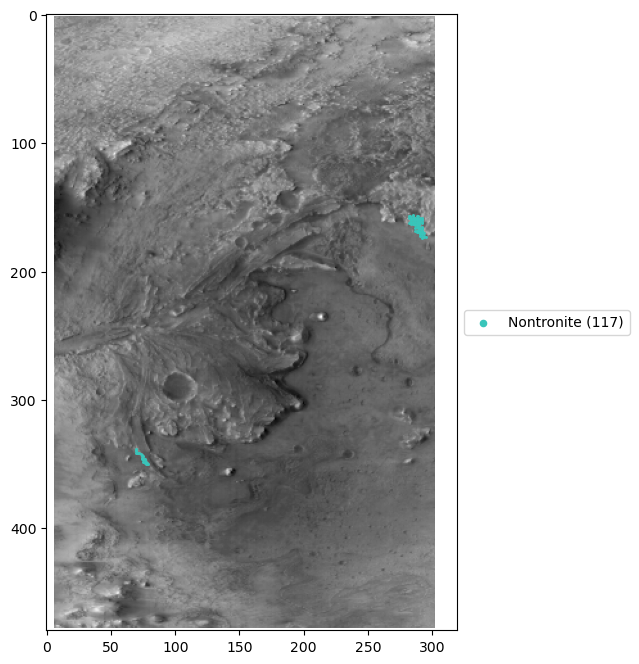

In [22]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(static_vis.get_image(60), cmap="gray")

coords = pred_coords[5]
ax.scatter(coords[0], coords[1], s=1.2, color=mineral_colours[CLASS_NAMES[5]], label=f"{CLASS_NAMES[5]} ({len(coords[0])})")

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

for handle in ax.get_legend().legend_handles:
    handle.set_sizes([20])

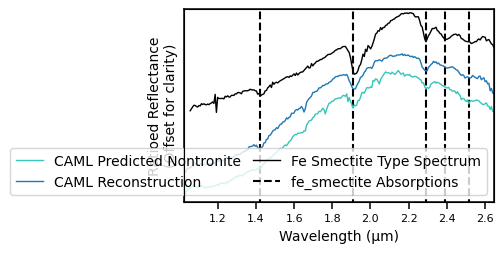

In [ ]:
mineral_class = 5
denoised_mineral = x_recon[
    pred_coords[mineral_class][1], pred_coords[mineral_class][0]
]
denoised_mineral = denoised_mineral.reshape(-1, 248)
denoised_mineral_avg = np.average(denoised_mineral, axis=0)
denoised_nontronite_avg = denoised_mineral_avg

original_mineral = ratioed_im.reshape((*im_shape[:2], 248))[
    pred_coords[mineral_class][1], pred_coords[mineral_class][0]
]
original_mineral = original_mineral.reshape(-1, 248)
original_mineral_avg = np.average(original_mineral, axis=0)
original_nontronite_avg = original_mineral_avg

# uses Plebani's pixel classes not mine
dummy_sample = pd.Series(
    [[PLATT_TO_PLEBANI[6]], *np.zeros(248)],
    index=["Pixel_Class", *[str(x) for x in PLEBANI_WAVELENGTHS[:248]]],
)
mineral_type_spec = get_type_spectra(
    dummy_sample, TYPE_SPECTRA_PATH
)
mineral_type_spec = clip_type_spectra(dummy_sample, mineral_type_spec)
type_spec_wavelengths = [float(x) for x in mineral_type_spec.index]

fig, ax = plt.subplots(figsize=(4, 2.5))
font_size = 10

ax2 = ax.twinx()
ax.plot(
    PLEBANI_WAVELENGTHS[:248],
    original_mineral_avg,
    linewidth=1.0,
    c=mineral_colours[CLASS_NAMES[mineral_class]],
    label=f"CAML Predicted {CLASS_NAMES[mineral_class]}",
)
ax.plot(
    PLEBANI_WAVELENGTHS[:248],
    denoised_mineral_avg + 0.01,
    linewidth=1.0,
    label="CAML Reconstruction",
)
ax2.plot(
    type_spec_wavelengths,
    mineral_type_spec.values,
    linewidth=1.0,
    c="black",
    label=f"{get_type_spectra_name(dummy_sample)} Type Spectrum",
)
ax.plot(
    PLEBANI_WAVELENGTHS[0],
    0,
    linewidth=1.0,
    c="black",
    label=f"{get_type_spectra_name(dummy_sample)} Type Spectrum",
)

type_spectra_class = get_type_spectra_class(dummy_sample)
absorption_feats = CRISM_diagnostic_mineral_features[type_spectra_class]
absorption_feats = [x for x in absorption_feats if x < 2.6]
ax.vlines(
    absorption_feats,
    ymin=1.07,
    ymax=1.2,
    color="black",
    linestyle="--",
    linewidth=1.5,
    label=f"{type_spectra_class} Absorptions",
    zorder=0,
)

for axis in [ax, ax2]:
    axis.set_yticks([])
    axis.set_yticklabels([])

ax.set_xlabel("Wavelength (μm)")
ax.set_ylabel("Ratioed Reflectance\n(Offset for clarity)")
ax.spines[:].set_linewidth(1.1)
ax.set_xlim(PLEBANI_WAVELENGTHS[0], PLEBANI_WAVELENGTHS[247])
ax.tick_params(
    axis="both", which="major", width=1.1, length=5, labelsize=font_size - 2
)
ax.tick_params(
    axis="both", which="minor", width=1.1, length=5, labelsize=font_size - 2
)

ax.set_ylim(1.08, 1.2)
ax2.set_ylim(1.2, 1.525)
ax.legend(loc="lower right", ncols=2, columnspacing=0.8)

Saponite

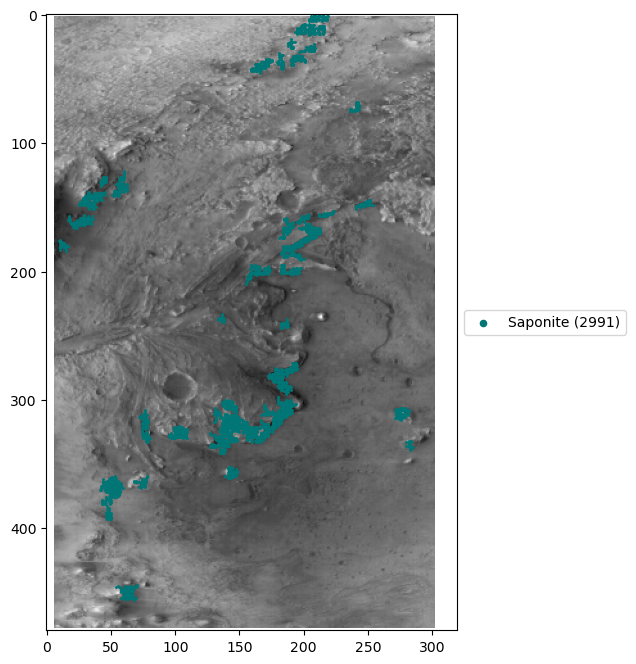

In [29]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(static_vis.get_image(60), cmap="gray")

mineral_class = 6
coords = pred_coords[mineral_class]
ax.scatter(coords[0], coords[1], s=1.2, color=mineral_colours[CLASS_NAMES[mineral_class]], label=f"{CLASS_NAMES[mineral_class]} ({len(coords[0])})")

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

for handle in ax.get_legend().legend_handles:
    handle.set_sizes([20])

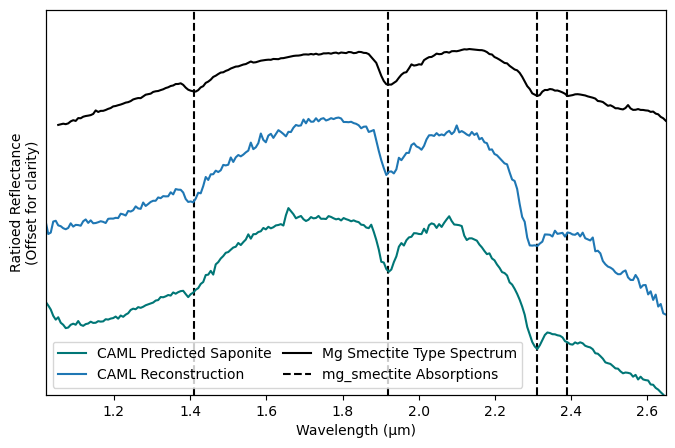

In [ ]:
mineral_class = 6
denoised_mineral = x_recon[pred_coords[mineral_class][1], pred_coords[mineral_class][0]]
denoised_mineral = denoised_mineral.reshape(-1, 248)
denoised_mineral_avg = np.average(denoised_mineral, axis=0)
denoised_saponite_avg = denoised_mineral_avg

original_mineral = ratioed_im.reshape((*im_shape[:2], 248))[pred_coords[mineral_class][1], pred_coords[mineral_class][0]]
original_mineral = original_mineral.reshape(-1, 248)
original_mineral_avg = np.average(original_mineral, axis=0)
original_saponite_avg = original_mineral_avg

dummy_sample = pd.Series([[PLATT_TO_PLEBANI[7]], *np.zeros(248)], index=["Pixel_Class", *[str(x) for x in PLEBANI_WAVELENGTHS[:248]]])
mineral_type_spec = get_type_spectra(dummy_sample, TYPE_SPECTRA_PATH)
mineral_type_spec = clip_type_spectra(dummy_sample, mineral_type_spec)
type_spec_wavelengths = [float(x) for x in mineral_type_spec.index]

fig, ax = plt.subplots(figsize=(8, 5))

ax2 = ax.twinx()
ax.plot(PLEBANI_WAVELENGTHS[:248], original_mineral_avg, c=mineral_colours[CLASS_NAMES[mineral_class]], label=f"CAML Predicted {CLASS_NAMES[mineral_class]}")
ax.plot(PLEBANI_WAVELENGTHS[:248], denoised_mineral_avg+0.01, label="CAML Reconstruction")
ax2.plot(type_spec_wavelengths, mineral_type_spec.values, c="black", label=f"{get_type_spectra_name(dummy_sample)} Type Spectrum")
ax.plot(PLEBANI_WAVELENGTHS[0], 0, c="black", label=f"{get_type_spectra_name(dummy_sample)} Type Spectrum")


type_spectra_class = get_type_spectra_class(dummy_sample)
absorption_feats = CRISM_diagnostic_mineral_features[type_spectra_class]
absorption_feats = [x for x in absorption_feats if x < 2.6]
ax.vlines(
    absorption_feats,
    ymin=0.96,
    ymax=1.01,
    color="black",
    linestyle="--",
    linewidth=1.5,
    label=f"{type_spectra_class} Absorptions",
    zorder=0
)

for axis in [ax, ax2]:
    axis.set_yticks([])
    axis.set_yticklabels([])

ax.set_xlabel("Wavelength (μm)")
ax.set_ylabel("Ratioed Reflectance\n(Offset for clarity)")
ax.set_xlim(PLEBANI_WAVELENGTHS[0], PLEBANI_WAVELENGTHS[247])
ax.tick_params(axis='both', which='major')
ax.tick_params(axis='both', which='minor')

ax.set_ylim(0.96, 1.01)
ax2.set_ylim(0.8, 1.28)
ax.legend(loc="lower left", ncols=2, columnspacing=0.8)

Combined Saponite and Nontronite plot

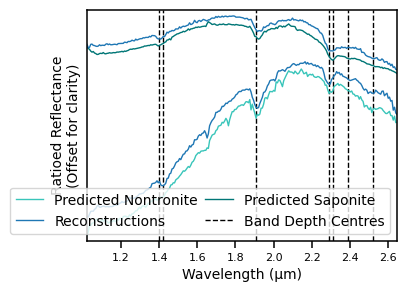

In [ ]:
fig, ax = plt.subplots(figsize=(4, 3))

font_size = 10

ax.plot(
    PLEBANI_WAVELENGTHS[:248],
    original_nontronite_avg,
    linewidth=1.0,
    c=mineral_colours["Nontronite"],
    label=f"Predicted Nontronite",
)
ax.plot(
    PLEBANI_WAVELENGTHS[:248],
    denoised_nontronite_avg + 0.003,
    linewidth=1.0,
    c="#1f77b4",
    label="Reconstructions",
)
ax.plot(
    PLEBANI_WAVELENGTHS[:248],
    original_saponite_avg + 0.2,
    linewidth=1.0,
    c=mineral_colours["Saponite"],
    label=f"Predicted Saponite",
)
ax.plot(
    PLEBANI_WAVELENGTHS[:248],
    denoised_saponite_avg + 0.201,
    linewidth=1.0,
    c="#1f77b4",
)

ax.vlines(
    [1.42, 1.40, 1.91, 2.29, 2.31, 2.39, 2.52],
    ymin=1.08,
    ymax=1.19,
    color="black",
    linestyle="--",
    linewidth=1.0,
    label="Band Depth Centres",
    zorder=0,
)

for axis in [ax]:
    axis.set_yticks([])
    axis.set_yticklabels([])

ax.spines[:].set_linewidth(1.1)
ax.set_xlabel("Wavelength (μm)")
ax.set_ylabel("Ratioed Reflectance\n(Offset for clarity)")
ax.set_xlim(PLEBANI_WAVELENGTHS[0], PLEBANI_WAVELENGTHS[247])
ax.tick_params(axis="both", which="major", width=1.1, length=5, labelsize=font_size - 2)
ax.tick_params(axis="both", which="minor", width=1.1, length=5, labelsize=font_size - 2)

ax.set_ylim(1.08, 1.19)
ax.legend(loc="lower right", ncols=2, columnspacing=0.5)

Jarosite

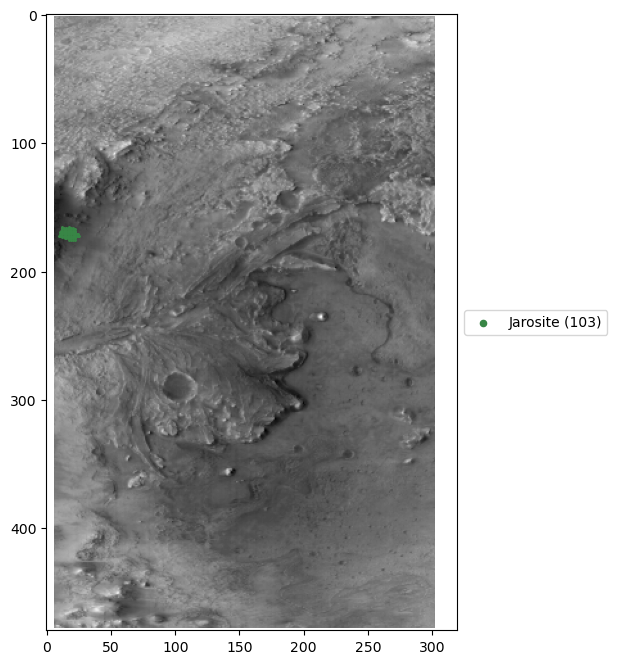

In [27]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(static_vis.get_image(60), cmap="gray")

mineral_class = 8
coords = pred_coords[mineral_class]
ax.scatter(coords[0], coords[1], s=1.2, color=mineral_colours[CLASS_NAMES[mineral_class]], label=f"{CLASS_NAMES[mineral_class]} ({len(coords[0])})")

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

for handle in ax.get_legend().legend_handles:
    handle.set_sizes([20])

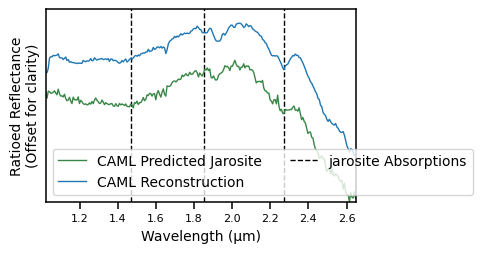

In [ ]:
mineral_class = 8
denoised_mineral = x_recon[
    pred_coords[mineral_class][1], pred_coords[mineral_class][0]
]
denoised_mineral = denoised_mineral.reshape(-1, 248)
denoised_mineral_avg = np.average(denoised_mineral, axis=0)

original_mineral = ratioed_im.reshape((*im_shape[:2], 248))[
    pred_coords[mineral_class][1], pred_coords[mineral_class][0]
]
original_mineral = original_mineral.reshape(-1, 248)
original_mineral_avg = np.average(original_mineral, axis=0)

dummy_sample = pd.Series(
    [[PLATT_TO_PLEBANI[9]], *np.zeros(248)],
    index=["Pixel_Class", *[str(x) for x in PLEBANI_WAVELENGTHS[:248]]],
)
mineral_type_spec = get_type_spectra(
    dummy_sample, TYPE_SPECTRA_PATH
)
mineral_type_spec = clip_type_spectra(dummy_sample, mineral_type_spec)
type_spec_wavelengths = [float(x) for x in mineral_type_spec.index]

fig, ax = plt.subplots(figsize=(4, 2.5))
font_size = 10

# ax2 = ax.twinx()
ax.plot(
    PLEBANI_WAVELENGTHS[:248],
    original_mineral_avg,
    linewidth=1.0,
    c=mineral_colours[CLASS_NAMES[mineral_class]],
    label=f"CAML Predicted {CLASS_NAMES[mineral_class]}",
)
ax.plot(
    PLEBANI_WAVELENGTHS[:248],
    denoised_mineral_avg + 0.01,
    linewidth=1.0,
    label="CAML Reconstruction",
)

type_spectra_class = get_type_spectra_class(dummy_sample)
absorption_feats = CRISM_diagnostic_mineral_features[type_spectra_class]
absorption_feats = [x for x in absorption_feats if x < 2.6]
ax.vlines(
    absorption_feats,
    ymin=0.97,
    ymax=1.03,
    color="black",
    linestyle="--",
    linewidth=1.0,
    label=f"{type_spectra_class} Absorptions",
    zorder=0,
)

for axis in [ax]:  # , ax2]:
    axis.set_yticks([])
    axis.set_yticklabels([])

ax.spines[:].set_linewidth(1.1)
ax.set_xlabel("Wavelength (μm)")
ax.set_ylabel("Ratioed Reflectance\n(Offset for clarity)")
ax.set_xlim(PLEBANI_WAVELENGTHS[0], PLEBANI_WAVELENGTHS[247])
ax.tick_params(axis="both", which="major", width=1.1, length=5, labelsize=font_size - 2)
ax.tick_params(axis="both", which="minor", width=1.1, length=5, labelsize=font_size - 2)

ax.set_ylim(0.97, 1.02)
# ax2.set_ylim(0.85, 1.1)
ax.legend(loc="lower left", ncols=2)

Carbonate

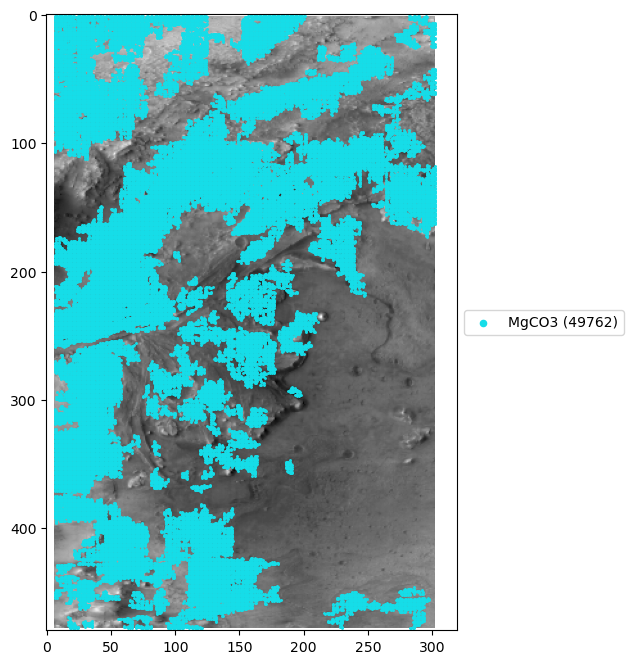

In [29]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(static_vis.get_image(60), cmap="gray")

mineral_class = 29
coords = pred_coords[mineral_class]
ax.scatter(coords[0], coords[1], s=1.2, color=mineral_colours[CLASS_NAMES[mineral_class]], label=f"{CLASS_NAMES[mineral_class]} ({len(coords[0])})")

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

for handle in ax.get_legend().legend_handles:
    handle.set_sizes([20])

Text(0.5, 1.0, 'Average MgCO3 Spectrum')

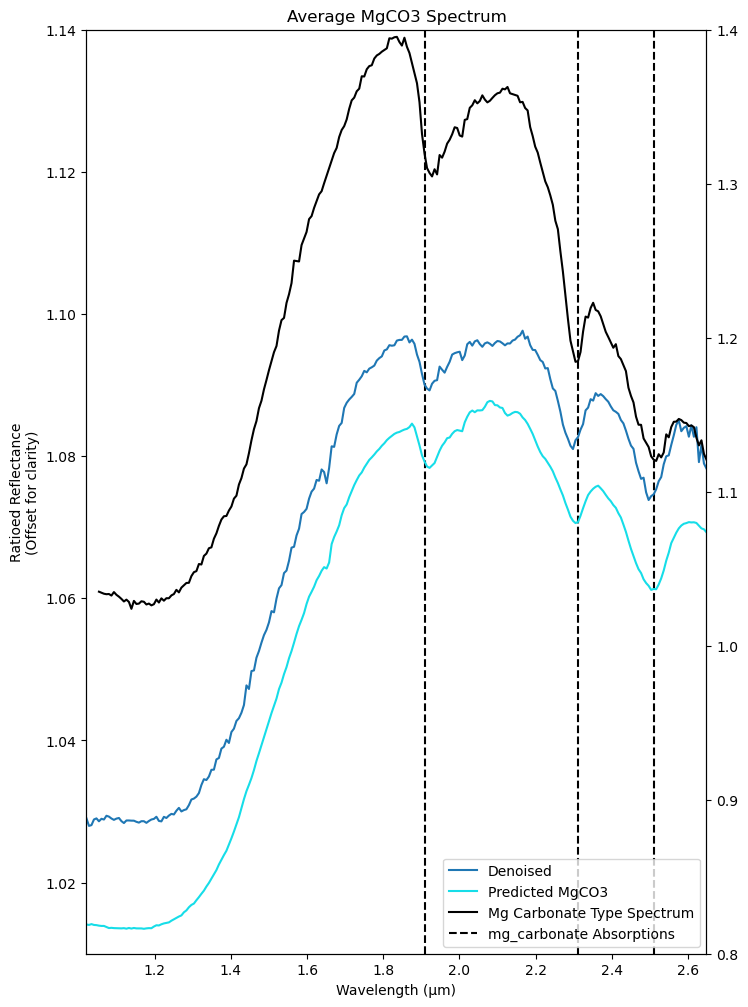

In [ ]:
mineral_class = 29
denoised_mineral = x_recon[pred_coords[mineral_class][1], pred_coords[mineral_class][0]]
denoised_mineral = denoised_mineral.reshape(-1, 248)
denoised_mineral_avg = np.average(denoised_mineral, axis=0)

original_mineral = ratioed_im.reshape((*im_shape[:2], 248))[pred_coords[mineral_class][1], pred_coords[mineral_class][0]]
original_mineral = original_mineral.reshape(-1, 248)
original_mineral_avg = np.average(original_mineral, axis=0)

dummy_sample = pd.Series([[PLATT_TO_PLEBANI[30]], *np.zeros(248)], index=["Pixel_Class", *[str(x) for x in PLEBANI_WAVELENGTHS[:248]]])
mineral_type_spec = get_type_spectra(dummy_sample, TYPE_SPECTRA_PATH)
mineral_type_spec = clip_type_spectra(dummy_sample, mineral_type_spec)
type_spec_wavelengths = [float(x) for x in mineral_type_spec.index]

fig, ax = plt.subplots(figsize=(8, 12))

ax2 = ax.twinx()
ax.plot(PLEBANI_WAVELENGTHS[:248], denoised_mineral_avg+0.01, label="Denoised")
ax.plot(PLEBANI_WAVELENGTHS[:248], original_mineral_avg, c=mineral_colours[CLASS_NAMES[mineral_class]], label=f"Predicted {CLASS_NAMES[mineral_class]}")
ax2.plot(type_spec_wavelengths, mineral_type_spec.values, c="black", label=f"{get_type_spectra_name(dummy_sample)} Type Spectrum")
ax.plot(PLEBANI_WAVELENGTHS[0], 0, c="black", label=f"{get_type_spectra_name(dummy_sample)} Type Spectrum")

type_spectra_class = get_type_spectra_class(dummy_sample)
absorption_feats = CRISM_diagnostic_mineral_features[type_spectra_class]
absorption_feats = [x for x in absorption_feats if x < 2.6]
ax.vlines(
    absorption_feats,
    ymin=1.01,
    ymax=1.14,
    color="black",
    linestyle="--",
    linewidth=1.5,
    label=f"{type_spectra_class} Absorptions",
    zorder=0
)

# for axis in [ax, ax2]:
#     axis.set_yticks([])
#     axis.set_yticklabels([])

ax.set_xlabel("Wavelength (μm)")
ax.set_ylabel("Ratioed Reflectance\n(Offset for clarity)")
ax.set_xlim(PLEBANI_WAVELENGTHS[0], PLEBANI_WAVELENGTHS[247])
ax.tick_params(axis='both', which='major')
ax.tick_params(axis='both', which='minor')

ax.set_ylim(1.01, 1.14)
ax2.set_ylim(0.8, 1.4)
ax.legend(loc="lower right")
ax.set_title("Average MgCO3 Spectrum")

Very high confidence (as expected)

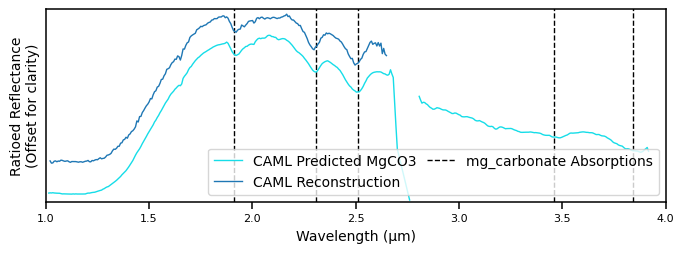

In [ ]:
mineral_class = 29

original_mineral = image.ratioed_image[
    pred_coords[mineral_class][1], pred_coords[mineral_class][0]
]
original_mineral = original_mineral.reshape(-1, 438)
original_mineral_avg = np.average(original_mineral, axis=0)
original_mineral_avg[original_mineral_avg > 2] = np.nan
original_mineral_avg[original_mineral_avg < 1.01] = np.nan


denoised_mineral = x_recon[
    pred_coords[mineral_class][1], pred_coords[mineral_class][0]
]
denoised_mineral = denoised_mineral.reshape(-1, 248)
denoised_mineral_avg = np.average(denoised_mineral, axis=0)

dummy_sample = pd.Series(
    [[PLATT_TO_PLEBANI[30]], *np.zeros(438)],
    index=["Pixel_Class", *[str(x) for x in ALL_WAVELENGTHS[:438]]],
)
mineral_type_spec = get_type_spectra(
    dummy_sample, TYPE_SPECTRA_PATH
)
mineral_type_spec = clip_type_spectra(dummy_sample, mineral_type_spec)
type_spec_wavelengths = [float(x) for x in mineral_type_spec.index]

fig, ax = plt.subplots(figsize=(8, 2.5))
font_size = 10

# ax2 = ax.twinx()
ax.plot(
    ALL_WAVELENGTHS,
    original_mineral_avg,
    linewidth=1.0,
    c=mineral_colours[CLASS_NAMES[mineral_class]],
    label=f"CAML Predicted {CLASS_NAMES[mineral_class]}",
)
ax.plot(
    PLEBANI_WAVELENGTHS[:248],
    denoised_mineral_avg + 0.01,
    linewidth=1.0,
    label="CAML Reconstruction",
)

type_spectra_class = get_type_spectra_class(dummy_sample)
absorption_feats = CRISM_diagnostic_mineral_features[type_spectra_class]
ax.vlines(
    absorption_feats,
    ymin=1.01,
    ymax=1.14,
    color="black",
    linestyle="--",
    linewidth=1.0,
    label=f"{type_spectra_class} Absorptions",
    zorder=0,
)

for axis in [ax]: #, ax2]:
    axis.set_yticks([])
    axis.set_yticklabels([])

ax.spines[:].set_linewidth(1.1)
ax.set_xlabel("Wavelength (μm)", fontsize=font_size)
ax.set_ylabel("Ratioed Reflectance\n(Offset for clarity)", fontsize=font_size)
ax.set_xlim(ALL_WAVELENGTHS[0], ALL_WAVELENGTHS[-1])
ax.set_xticks(np.arange(1.0, 4.5, 0.5))
ax.tick_params(
    axis="both", which="major", width=1.1, length=5, labelsize=font_size - 2
)
ax.tick_params(
    axis="both", which="minor", width=1.1, length=5, labelsize=font_size - 2
)

ax.set_ylim(1.01, 1.10)
ax.legend(loc="lower right", ncols=2, columnspacing=0.8)

Chloride

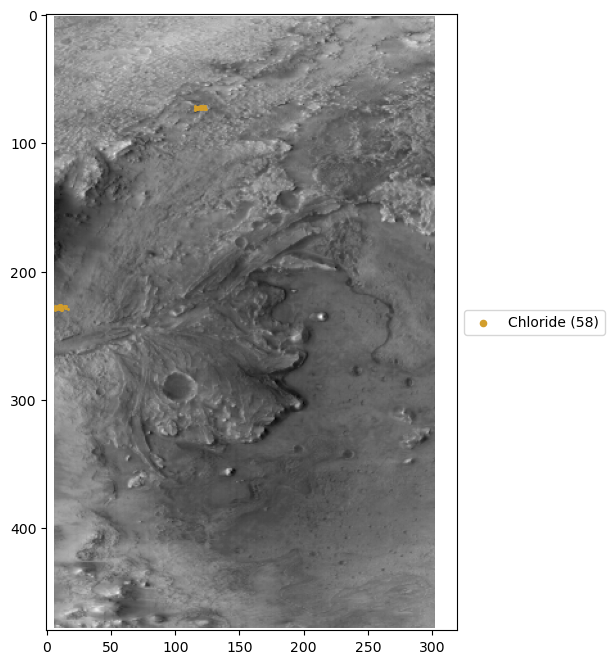

In [48]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(static_vis.get_image(60), cmap="gray")

mineral_class = 36
coords = pred_coords[mineral_class]
ax.scatter(coords[0], coords[1], s=1.2, color=mineral_colours[CLASS_NAMES[mineral_class]], label=f"{CLASS_NAMES[mineral_class]} ({len(coords[0])})")

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

for handle in ax.get_legend().legend_handles:
    handle.set_sizes([20])

Text(0.5, 1.0, 'Average Chloride Spectrum')

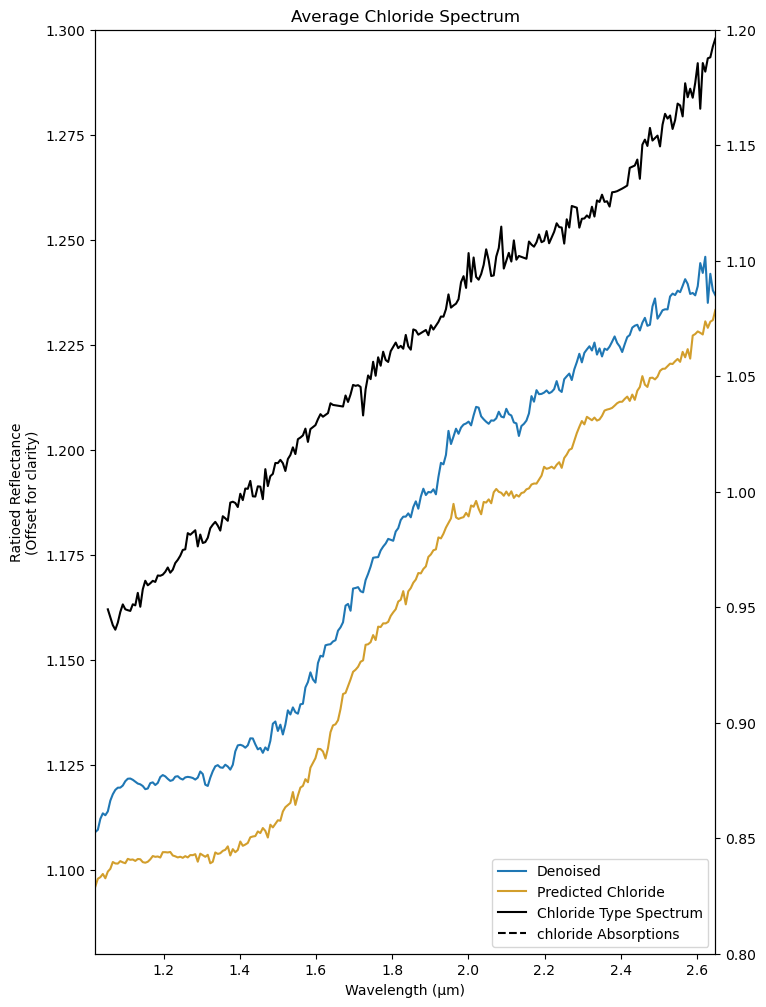

In [ ]:
mineral_class = 36
denoised_mineral = x_recon[pred_coords[mineral_class][1], pred_coords[mineral_class][0]]
denoised_mineral = denoised_mineral.reshape(-1, 248)
denoised_mineral_avg = np.average(denoised_mineral, axis=0)

original_mineral = ratioed_im.reshape((*im_shape[:2], 248))[pred_coords[mineral_class][1], pred_coords[mineral_class][0]]
original_mineral = original_mineral.reshape(-1, 248)
original_mineral_avg = np.average(original_mineral, axis=0)

dummy_sample = pd.Series([[PLATT_TO_PLEBANI[37]], *np.zeros(248)], index=["Pixel_Class", *[str(x) for x in PLEBANI_WAVELENGTHS[:248]]])
mineral_type_spec = get_type_spectra(dummy_sample, TYPE_SPECTRA_PATH)
mineral_type_spec = clip_type_spectra(dummy_sample, mineral_type_spec)
type_spec_wavelengths = [float(x) for x in mineral_type_spec.index]

fig, ax = plt.subplots(figsize=(8, 12))

ax2 = ax.twinx()
ax.plot(PLEBANI_WAVELENGTHS[:248], denoised_mineral_avg+0.01, label="Denoised")
ax.plot(PLEBANI_WAVELENGTHS[:248], original_mineral_avg, c=mineral_colours[CLASS_NAMES[mineral_class]], label=f"Predicted {CLASS_NAMES[mineral_class]}")
ax2.plot(type_spec_wavelengths, mineral_type_spec.values, c="black", label=f"{get_type_spectra_name(dummy_sample)} Type Spectrum")
ax.plot(PLEBANI_WAVELENGTHS[0], 0, c="black", label=f"{get_type_spectra_name(dummy_sample)} Type Spectrum")

type_spectra_class = get_type_spectra_class(dummy_sample)
absorption_feats = CRISM_diagnostic_mineral_features[type_spectra_class]
absorption_feats = [x for x in absorption_feats if x < 2.6]
ax.vlines(
    absorption_feats,
    ymin=0.98,
    ymax=1.06,
    color="black",
    linestyle="--",
    linewidth=1.5,
    label=f"{type_spectra_class} Absorptions",
    zorder=0
)

ax.set_xlabel("Wavelength (μm)")
ax.set_ylabel("Ratioed Reflectance\n(Offset for clarity)")
ax.set_xlim(PLEBANI_WAVELENGTHS[0], PLEBANI_WAVELENGTHS[247])
ax.tick_params(axis='both', which='major')
ax.tick_params(axis='both', which='minor')

ax.set_ylim(1.08, 1.3)
ax2.set_ylim(0.8, 1.2)
ax.legend(loc="lower right")
ax.set_title("Average Chloride Spectrum")

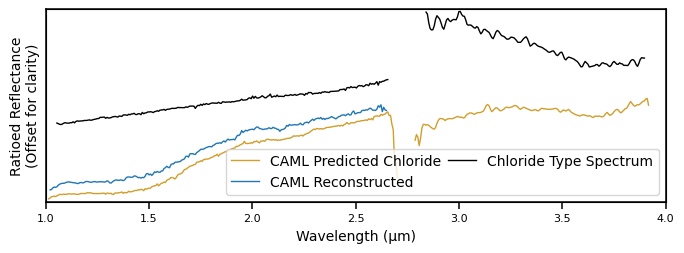

In [ ]:
mineral_class = 36

original_mineral = image.ratioed_image[
    pred_coords[mineral_class][1], pred_coords[mineral_class][0]
]
original_mineral = original_mineral.reshape(-1, 438)
original_mineral_avg = np.average(original_mineral, axis=0)
original_mineral_avg[original_mineral_avg > 2] = np.nan
original_mineral_avg[original_mineral_avg < 1.08] = (
    np.nan
)  # beware, this is a hacky vis trick

denoised_mineral = x_recon[
    pred_coords[mineral_class][1], pred_coords[mineral_class][0]
]
denoised_mineral = denoised_mineral.reshape(-1, 248)
denoised_mineral_avg = np.average(denoised_mineral, axis=0)


dummy_sample = pd.Series(
    [[PLATT_TO_PLEBANI[37]], *np.zeros(438)],
    index=["Pixel_Class", *[str(x) for x in ALL_WAVELENGTHS[:438]]],
)
mineral_type_spec = get_type_spectra(
    dummy_sample, TYPE_SPECTRA_PATH
)
mineral_type_spec = clip_type_spectra(dummy_sample, mineral_type_spec)
type_spec_wavelengths = [float(x) for x in mineral_type_spec.index]

fig, ax = plt.subplots(figsize=(8, 2.5))
font_size = 10

ax2 = ax.twinx()
ax.plot(
    ALL_WAVELENGTHS,
    original_mineral_avg,
    linewidth=1.0,
    c=mineral_colours[CLASS_NAMES[mineral_class]],
    label=f"CAML Predicted {CLASS_NAMES[mineral_class]}",
)
ax.plot(
    PLEBANI_WAVELENGTHS[:248],
    denoised_mineral_avg + 0.01,
    linewidth=1.0,
    label="CAML Reconstructed",
)
ax2.plot(
    type_spec_wavelengths[:227],
    mineral_type_spec.values[:227],
    linewidth=1.0,
    c="black",
    label=f"{get_type_spectra_name(dummy_sample)} Type Spectrum",
)
ax2.plot(
    type_spec_wavelengths[227:],
    mineral_type_spec.values[227:],
    linewidth=1.0,
    c="black",
    label=f"{get_type_spectra_name(dummy_sample)} Type Spectrum",
)
ax.plot(
    PLEBANI_WAVELENGTHS[0],
    0,
    linewidth=1.0,
    c="black",
    label=f"{get_type_spectra_name(dummy_sample)} Type Spectrum",
)

type_spectra_class = get_type_spectra_class(dummy_sample)
absorption_feats = CRISM_diagnostic_mineral_features[type_spectra_class]

for axis in [ax, ax2]:
    axis.set_yticks([])
    axis.set_yticklabels([])

ax.spines[:].set_linewidth(1.1)
ax.set_xlabel("Wavelength (μm)", fontsize=font_size)
ax.set_ylabel("Ratioed Reflectance\n(Offset for clarity)", fontsize=font_size)
ax.tick_params(
    axis="both", which="major", width=1.1, length=5, labelsize=font_size - 2
)
ax.tick_params(
    axis="both", which="minor", width=1.1, length=5, labelsize=font_size - 2
)
ax.set_xlim(ALL_WAVELENGTHS[0], ALL_WAVELENGTHS[-1])
ax.set_xticks(np.arange(1.0, 4.5, 0.5))


ax.set_ylim(1.09, 1.4)
ax2.set_ylim(0.5, 1.6)
ax.legend(loc="lower right", ncols=2, columnspacing=0.5)

LCP

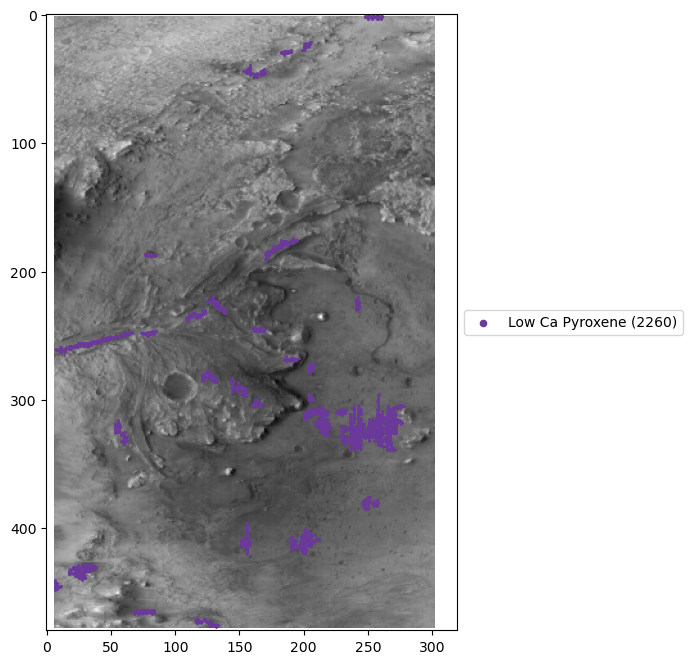

In [79]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(static_vis.get_image(60), cmap="gray")

mineral_class = 32
coords = pred_coords[mineral_class]
ax.scatter(coords[0], coords[1], s=1.2, color=mineral_colours[CLASS_NAMES[mineral_class]], label=f"{CLASS_NAMES[mineral_class]} ({len(coords[0])})")

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

for handle in ax.get_legend().legend_handles:
    handle.set_sizes([20])

Text(0.5, 1.0, 'Average LCP Spectrum')

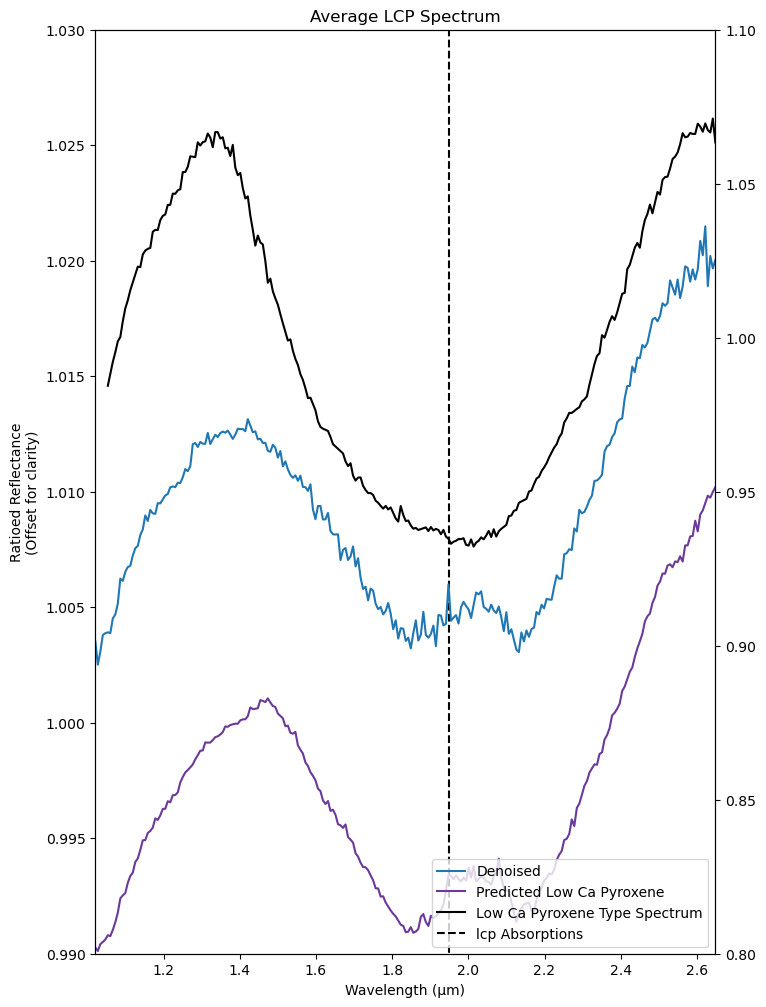

In [ ]:
mineral_class = 32
denoised_mineral = x_recon[pred_coords[mineral_class][1], pred_coords[mineral_class][0]]
denoised_mineral = denoised_mineral.reshape(-1, 248)
denoised_mineral_avg = np.average(denoised_mineral, axis=0)
lcp_denoised_avg = denoised_mineral_avg

original_mineral = ratioed_im.reshape((*im_shape[:2], 248))[pred_coords[mineral_class][1], pred_coords[mineral_class][0]]
original_mineral = original_mineral.reshape(-1, 248)
original_mineral_avg = np.average(original_mineral, axis=0)
lcp_mineral_avg = original_mineral_avg

dummy_sample = pd.Series([[PLATT_TO_PLEBANI[33]], *np.zeros(248)], index=["Pixel_Class", *[str(x) for x in PLEBANI_WAVELENGTHS[:248]]])
mineral_type_spec = get_type_spectra(dummy_sample, TYPE_SPECTRA_PATH)
mineral_type_spec = clip_type_spectra(dummy_sample, mineral_type_spec)
type_spec_wavelengths = [float(x) for x in mineral_type_spec.index]

fig, ax = plt.subplots(figsize=(8, 12))

ax2 = ax.twinx()
ax.plot(PLEBANI_WAVELENGTHS[:248], denoised_mineral_avg+0.01, label="Denoised")
ax.plot(PLEBANI_WAVELENGTHS[:248], original_mineral_avg, c=mineral_colours[CLASS_NAMES[mineral_class]], label=f"Predicted {CLASS_NAMES[mineral_class]}")
ax2.plot(type_spec_wavelengths, mineral_type_spec.values, c="black", label=f"{get_type_spectra_name(dummy_sample)} Type Spectrum")
ax.plot(PLEBANI_WAVELENGTHS[0], 0, c="black", label=f"{get_type_spectra_name(dummy_sample)} Type Spectrum")

type_spectra_class = get_type_spectra_class(dummy_sample)
absorption_feats = CRISM_diagnostic_mineral_features[type_spectra_class]
absorption_feats = [x for x in absorption_feats if x < 2.6]
ax.vlines(
    absorption_feats,
    ymin=0.98,
    ymax=1.06,
    color="black",
    linestyle="--",
    linewidth=1.5,
    label=f"{type_spectra_class} Absorptions",
    zorder=0
)

ax.set_xlabel("Wavelength (μm)")
ax.set_ylabel("Ratioed Reflectance\n(Offset for clarity)")
ax.set_xlim(PLEBANI_WAVELENGTHS[0], PLEBANI_WAVELENGTHS[247])
ax.tick_params(axis='both', which='major')
ax.tick_params(axis='both', which='minor')

ax.set_ylim(0.99, 1.03)
ax2.set_ylim(0.8, 1.1)
ax.legend(loc="lower right")
ax.set_title("Average LCP Spectrum")

HCP

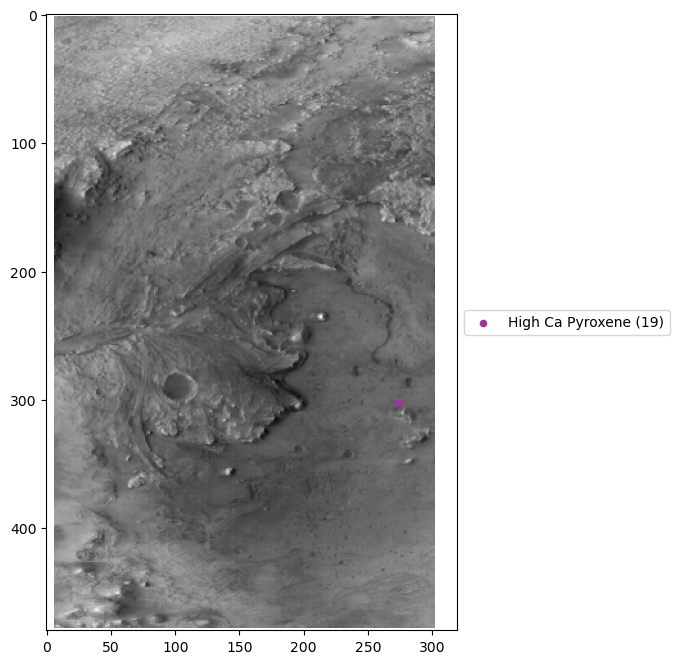

In [81]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(static_vis.get_image(60), cmap="gray")

mineral_class = 34
coords = pred_coords[mineral_class]
ax.scatter(coords[0], coords[1], s=1.2, color=mineral_colours[CLASS_NAMES[mineral_class]], label=f"{CLASS_NAMES[mineral_class]} ({len(coords[0])})")

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

for handle in ax.get_legend().legend_handles:
    handle.set_sizes([20])

Text(0.5, 1.0, 'Average HCP Spectrum')

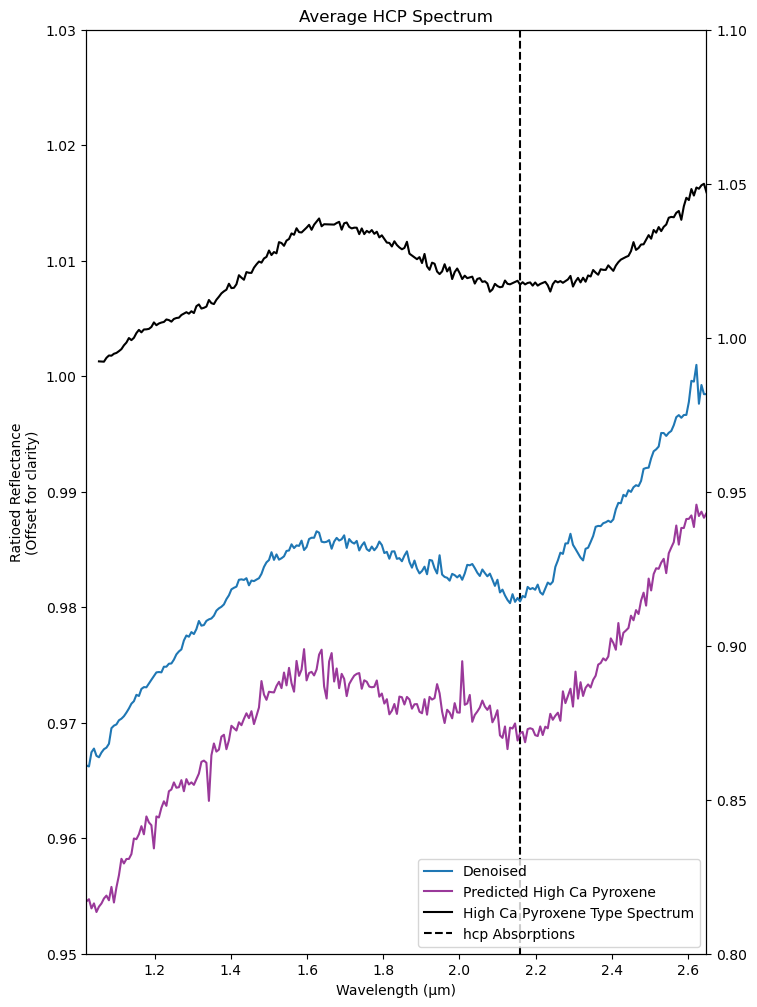

In [ ]:
mineral_class = 34
denoised_mineral = x_recon[pred_coords[mineral_class][1], pred_coords[mineral_class][0]]
denoised_mineral = denoised_mineral.reshape(-1, 248)
denoised_mineral_avg = np.average(denoised_mineral, axis=0)
hcp_denoised_avg = denoised_mineral_avg

original_mineral = ratioed_im.reshape((*im_shape[:2], 248))[pred_coords[mineral_class][1], pred_coords[mineral_class][0]]
original_mineral = original_mineral.reshape(-1, 248)
original_mineral_avg = np.average(original_mineral, axis=0)
hcp_mineral_avg = original_mineral_avg

dummy_sample = pd.Series([[PLATT_TO_PLEBANI[35]], *np.zeros(248)], index=["Pixel_Class", *[str(x) for x in PLEBANI_WAVELENGTHS[:248]]])
mineral_type_spec = get_type_spectra(dummy_sample, TYPE_SPECTRA_PATH)
mineral_type_spec = clip_type_spectra(dummy_sample, mineral_type_spec)
type_spec_wavelengths = [float(x) for x in mineral_type_spec.index]

fig, ax = plt.subplots(figsize=(8, 12))

ax2 = ax.twinx()
ax.plot(PLEBANI_WAVELENGTHS[:248], denoised_mineral_avg+0.01, label="Denoised")
ax.plot(PLEBANI_WAVELENGTHS[:248], original_mineral_avg, c=mineral_colours[CLASS_NAMES[mineral_class]], label=f"Predicted {CLASS_NAMES[mineral_class]}")
ax2.plot(type_spec_wavelengths, mineral_type_spec.values, c="black", label=f"{get_type_spectra_name(dummy_sample)} Type Spectrum")
ax.plot(PLEBANI_WAVELENGTHS[0], 0, c="black", label=f"{get_type_spectra_name(dummy_sample)} Type Spectrum")

type_spectra_class = get_type_spectra_class(dummy_sample)
absorption_feats = CRISM_diagnostic_mineral_features[type_spectra_class]
absorption_feats = [x for x in absorption_feats if x < 2.6]
ax.vlines(
    absorption_feats,
    ymin=0.95,
    ymax=1.03,
    color="black",
    linestyle="--",
    linewidth=1.5,
    label=f"{type_spectra_class} Absorptions",
    zorder=0
)

ax.set_xlabel("Wavelength (μm)")
ax.set_ylabel("Ratioed Reflectance\n(Offset for clarity)")
ax.set_xlim(PLEBANI_WAVELENGTHS[0], PLEBANI_WAVELENGTHS[247])
ax.tick_params(axis='both', which='major')
ax.tick_params(axis='both', which='minor')

ax.set_ylim(0.95, 1.03)
ax2.set_ylim(0.8, 1.1)
ax.legend(loc="lower right")
ax.set_title("Average HCP Spectrum")

Olivine

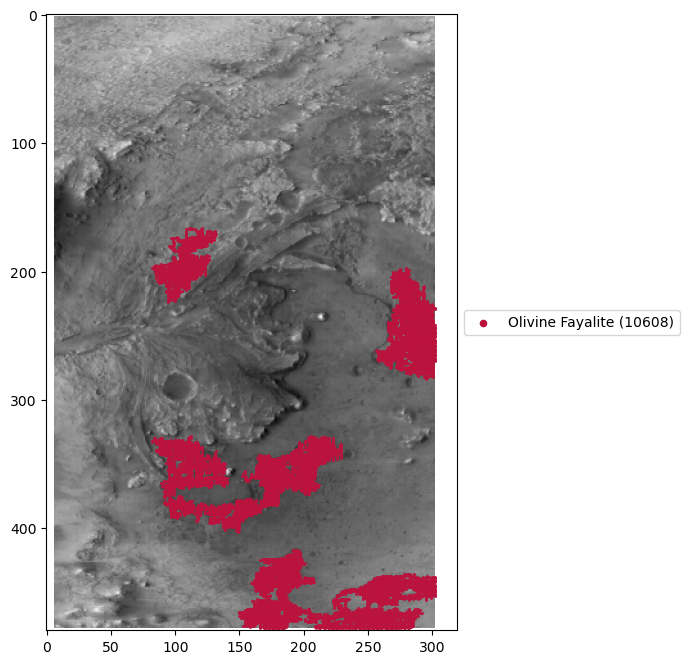

In [83]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(static_vis.get_image(60), cmap="gray")

mineral_class = 35
coords = pred_coords[mineral_class]
ax.scatter(coords[0], coords[1], s=1.2, color=mineral_colours[CLASS_NAMES[mineral_class]], label=f"{CLASS_NAMES[mineral_class]} ({len(coords[0])})")

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

for handle in ax.get_legend().legend_handles:
    handle.set_sizes([20])

Text(0.5, 1.0, 'Average Olivine Fayalite Spectrum')

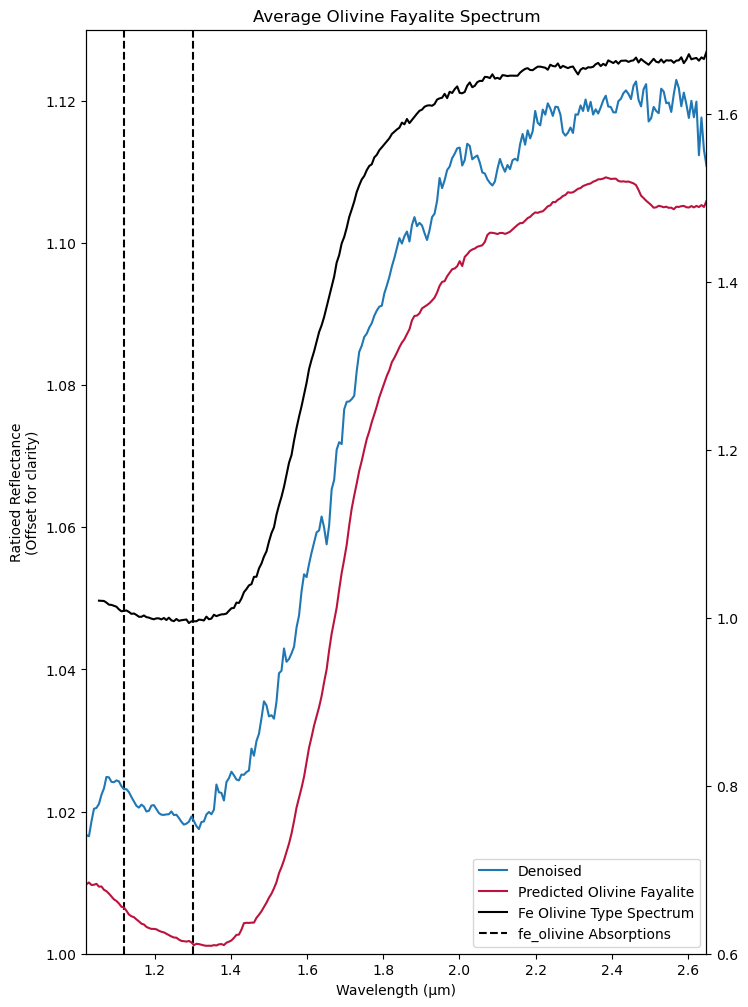

In [ ]:
mineral_class = 35
denoised_mineral = x_recon[pred_coords[mineral_class][1], pred_coords[mineral_class][0]]
denoised_mineral = denoised_mineral.reshape(-1, 248)
denoised_mineral_avg = np.average(denoised_mineral, axis=0)
olivine_denoised_avg = denoised_mineral_avg

original_mineral = ratioed_im.reshape((*im_shape[:2], 248))[pred_coords[mineral_class][1], pred_coords[mineral_class][0]]
original_mineral = original_mineral.reshape(-1, 248)
original_mineral_avg = np.average(original_mineral, axis=0)
olivine_mineral_avg = original_mineral_avg

dummy_sample = pd.Series([[PLATT_TO_PLEBANI[36]], *np.zeros(248)], index=["Pixel_Class", *[str(x) for x in PLEBANI_WAVELENGTHS[:248]]])
mineral_type_spec = get_type_spectra(dummy_sample, TYPE_SPECTRA_PATH)
mineral_type_spec = clip_type_spectra(dummy_sample, mineral_type_spec)
type_spec_wavelengths = [float(x) for x in mineral_type_spec.index]

fig, ax = plt.subplots(figsize=(8, 12))

ax2 = ax.twinx()
ax.plot(PLEBANI_WAVELENGTHS[:248], denoised_mineral_avg+0.01, label="Denoised")
ax.plot(PLEBANI_WAVELENGTHS[:248], original_mineral_avg, c=mineral_colours[CLASS_NAMES[mineral_class]], label=f"Predicted {CLASS_NAMES[mineral_class]}")
ax2.plot(type_spec_wavelengths, mineral_type_spec.values, c="black", label=f"{get_type_spectra_name(dummy_sample)} Type Spectrum")
ax.plot(PLEBANI_WAVELENGTHS[0], 0, c="black", label=f"{get_type_spectra_name(dummy_sample)} Type Spectrum")

type_spectra_class = get_type_spectra_class(dummy_sample)
absorption_feats = CRISM_diagnostic_mineral_features[type_spectra_class]
absorption_feats = [x for x in absorption_feats if x < 2.6]
ax.vlines(
    absorption_feats,
    ymin=1,
    ymax=1.13,
    color="black",
    linestyle="--",
    linewidth=1.5,
    label=f"{type_spectra_class} Absorptions",
    zorder=0
)

ax.set_xlabel("Wavelength (μm)")
ax.set_ylabel("Ratioed Reflectance\n(Offset for clarity)")
ax.set_xlim(PLEBANI_WAVELENGTHS[0], PLEBANI_WAVELENGTHS[247])
ax.tick_params(axis='both', which='major')
ax.tick_params(axis='both', which='minor')

ax.set_ylim(1, 1.13)
ax2.set_ylim(0.6, 1.7)
ax.legend(loc="lower right")
ax.set_title("Average Olivine Fayalite Spectrum")

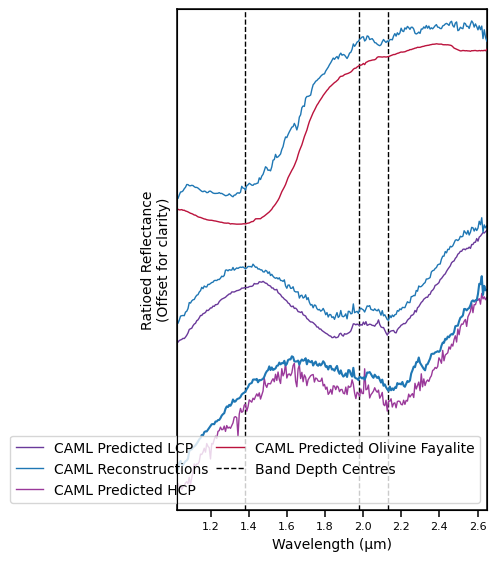

In [ ]:
fig, ax = plt.subplots(figsize=(4, 6.5))
font_size = 10
ax2 = ax.twinx()
ax2.plot(
    PLEBANI_WAVELENGTHS[:248],
    olivine_mineral_avg,
    linewidth=1.0,
    c=mineral_colours["Olivine Fayalite"],
    label=f"CAML Predicted Olivine Fayalite",
)
ax2.plot(
    PLEBANI_WAVELENGTHS[:248],
    olivine_denoised_avg + 0.01,
    linewidth=1.0,
    c="#1f77b4",
    label="CAML Olivine Fayalite Reconstruction",
)
ax.plot(
    PLEBANI_WAVELENGTHS[:248],
    lcp_mineral_avg,
    linewidth=1.0,
    c=mineral_colours["Low Ca Pyroxene"],
    label=f"CAML Predicted LCP",
)
ax.plot(
    PLEBANI_WAVELENGTHS[:248],
    lcp_denoised_avg + 0.001,
    linewidth=1.0,
    c="#1f77b4",
    label="CAML Reconstructions",
)
ax.plot(
    PLEBANI_WAVELENGTHS[:248],
    hcp_mineral_avg + 0.01,
    linewidth=1.0,
    c=mineral_colours["High Ca Pyroxene"],
    label=f"CAML Predicted HCP",
)
ax.plot(
    PLEBANI_WAVELENGTHS[:248],
    hcp_denoised_avg + 0.011,
    linewidth=1.0,
    c="#1f77b4",
)
ax.plot(
    PLEBANI_WAVELENGTHS[0],
    0,
    linewidth=1.0,
    c=mineral_colours["Olivine Fayalite"],
    label=f"CAML Predicted Olivine Fayalite",
)
ax.plot(PLEBANI_WAVELENGTHS[0], 0, c="#1f77b4")

ax.vlines(
    [1.38, 1.98, 2.13],
    ymin=0.96,
    ymax=1.05,
    color="black",
    linestyle="--",
    linewidth=1.0,
    label="Band Depth Centres",
    zorder=0,
)

for axis in [ax, ax2]:
    axis.set_yticks([])
    axis.set_yticklabels([])

ax.spines[:].set_linewidth(1.1)
ax.set_xlabel("Wavelength (μm)", fontsize=font_size)
ax.set_ylabel("Ratioed Reflectance\n(Offset for clarity)", fontsize=font_size)
ax.tick_params(
    axis="both", which="major", width=1.1, length=5, labelsize=font_size - 2
)
ax.tick_params(
    axis="both", which="minor", width=1.1, length=5, labelsize=font_size - 2
)
ax.set_xlim(PLEBANI_WAVELENGTHS[0], PLEBANI_WAVELENGTHS[247])

ax.set_ylim(0.96, 1.05)
ax2.set_ylim(0.83, 1.13)
ax.legend(loc="lower right", ncols=2, columnspacing=0.5)